In [53]:
import pandas as pd
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
from imblearn.over_sampling import SMOTE

In [64]:
class DataExplorer:
    @staticmethod
    def explore_data(data):
        print(data.head().T)
        print(data.describe())
        print(data.info())

    @staticmethod
    def target_classes_distribution(data):
        # Plotting the Performance distribution
        plt.figure(figsize=(8, 6))
        performance_counts = data['Performance'].value_counts(normalize=True) * 100
        ax = sns.barplot(x=performance_counts.index, y=performance_counts.values, palette='viridis')
        plt.title('Performance Class Distribution (%)')
        plt.xlabel('Performance')
        plt.ylabel('Percentage')

        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                        textcoords='offset points')
        
        plt.show()

    @staticmethod
    def plot_heat_map(my_df):
        cat_encoder = LabelEncoder()
        lista_colmuns = [col for col in my_df.columns]
        
        for col in lista_colmuns:
            my_df[col] = cat_encoder.fit_transform(my_df[col])

        corr_matrix = my_df.corr()
        plt.figure(figsize=(10, 10))
        plt.title('Relationship between Performance')
        sns.heatmap(corr_matrix, annot=True)
        plt.show()

    @staticmethod
    def pivot_tables(data):
        x_variables = data.drop(columns=['Performance']).columns
        num_vars = len(x_variables)
        num_cols = 3  # Number of columns for subplots
        num_rows = (num_vars + num_cols - 1) // num_cols

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
        axes = axes.flatten()

        for i, x_var in enumerate(x_variables):
            pivot = pd.pivot_table(data, index=x_var, columns='Performance', aggfunc='size', fill_value=0)
            sns.heatmap(pivot, annot=True, cmap='Blues', fmt='d', ax=axes[i])
            axes[i].set_title(f'Performance by {x_var}')
            axes[i].tick_params(axis='x', rotation=45)

        # Hide any extra subplots
        for i in range(num_vars, len(axes)):
            fig.delaxes(axes[i])

        plt.tight_layout()
        plt.show()

class Model:
    def __init__(self, filepath):
        self.filepath = filepath
        self.model_pipeline = Pipeline([
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
        ])
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4

    def load_data(self):
        data, meta = arff.loadarff(self.filepath)
        self.data = pd.DataFrame(data)
        self.data = self.data.apply(lambda col: col.apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x))  # Encoding from byte to string
        DataExplorer.explore_data(self.data)
        DataExplorer.target_classes_distribution(self.data)
        DataExplorer.pivot_tables(self.data)
        return self

    def preprocess_data(self):
        # Separate target column before one-hot encoding
        y = self.data['Performance']
        X = self.data.drop('Performance', axis=1)
        
        # One-Hot Encode categorical features
        X = pd.get_dummies(X, drop_first=True)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return self

    def train_model(self):
        self.model_pipeline.fit(self.X_train, self.y_train)
        return self

    def evaluate_model(self):
        print("Model Evaluation:")
        y_pred = self.model_pipeline.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(self.y_test))
        disp.plot(cmap='Blues')
        plt.show()
        report = classification_report(self.y_test, y_pred)
        print("Classification Report:")
        print(report)
        return self

    def cross_validate_model(self):
        scores = cross_val_score(self.model_pipeline, self.X_train, self.y_train, cv=5)
        print("Average Accuracy with CV:", np.mean(scores))
        return self

    def run_pipeline(self):
        (self.load_data()
             .preprocess_data()
             .train_model()
             .evaluate_model()
             .cross_validate_model())

                              0               1           2               3  \
Performance           Excellent       Excellent   Excellent       Excellent   
Gender                     male            male        male            male   
Caste                   General             OBC         OBC         General   
coaching                     NO              WA          OA              WA   
time                        ONE             TWO         TWO             ONE   
Class_ten_education        SEBA            SEBA      OTHERS            SEBA   
twelve_education          AHSEC           AHSEC        CBSE           AHSEC   
medium                  ENGLISH          OTHERS     ENGLISH          OTHERS   
Class_ X_Percentage   Excellent       Excellent   Excellent       Excellent   
Class_XII_Percentage  Excellent       Excellent   Excellent       Excellent   
Father_occupation        DOCTOR  SCHOOL_TEACHER    BUSINESS  SCHOOL_TEACHER   
Mother_occupation        OTHERS      HOUSE_WIFE  HOU

/tmp/ipykernel_2046/1639216544.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=performance_counts.index, y=performance_counts.values, palette='viridis')


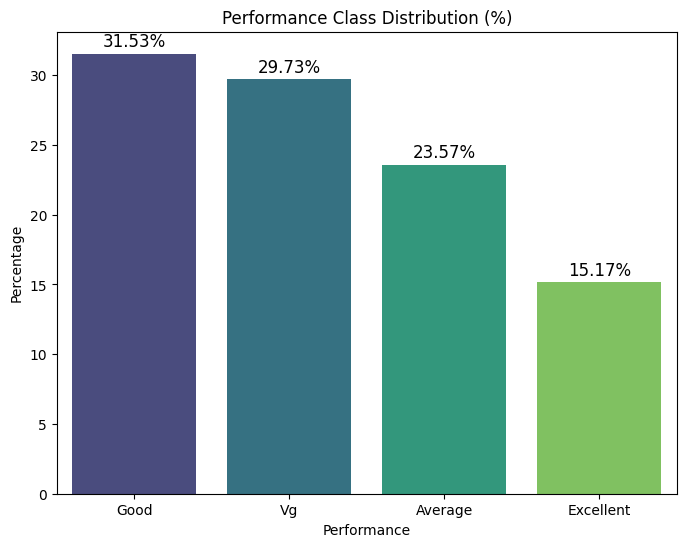

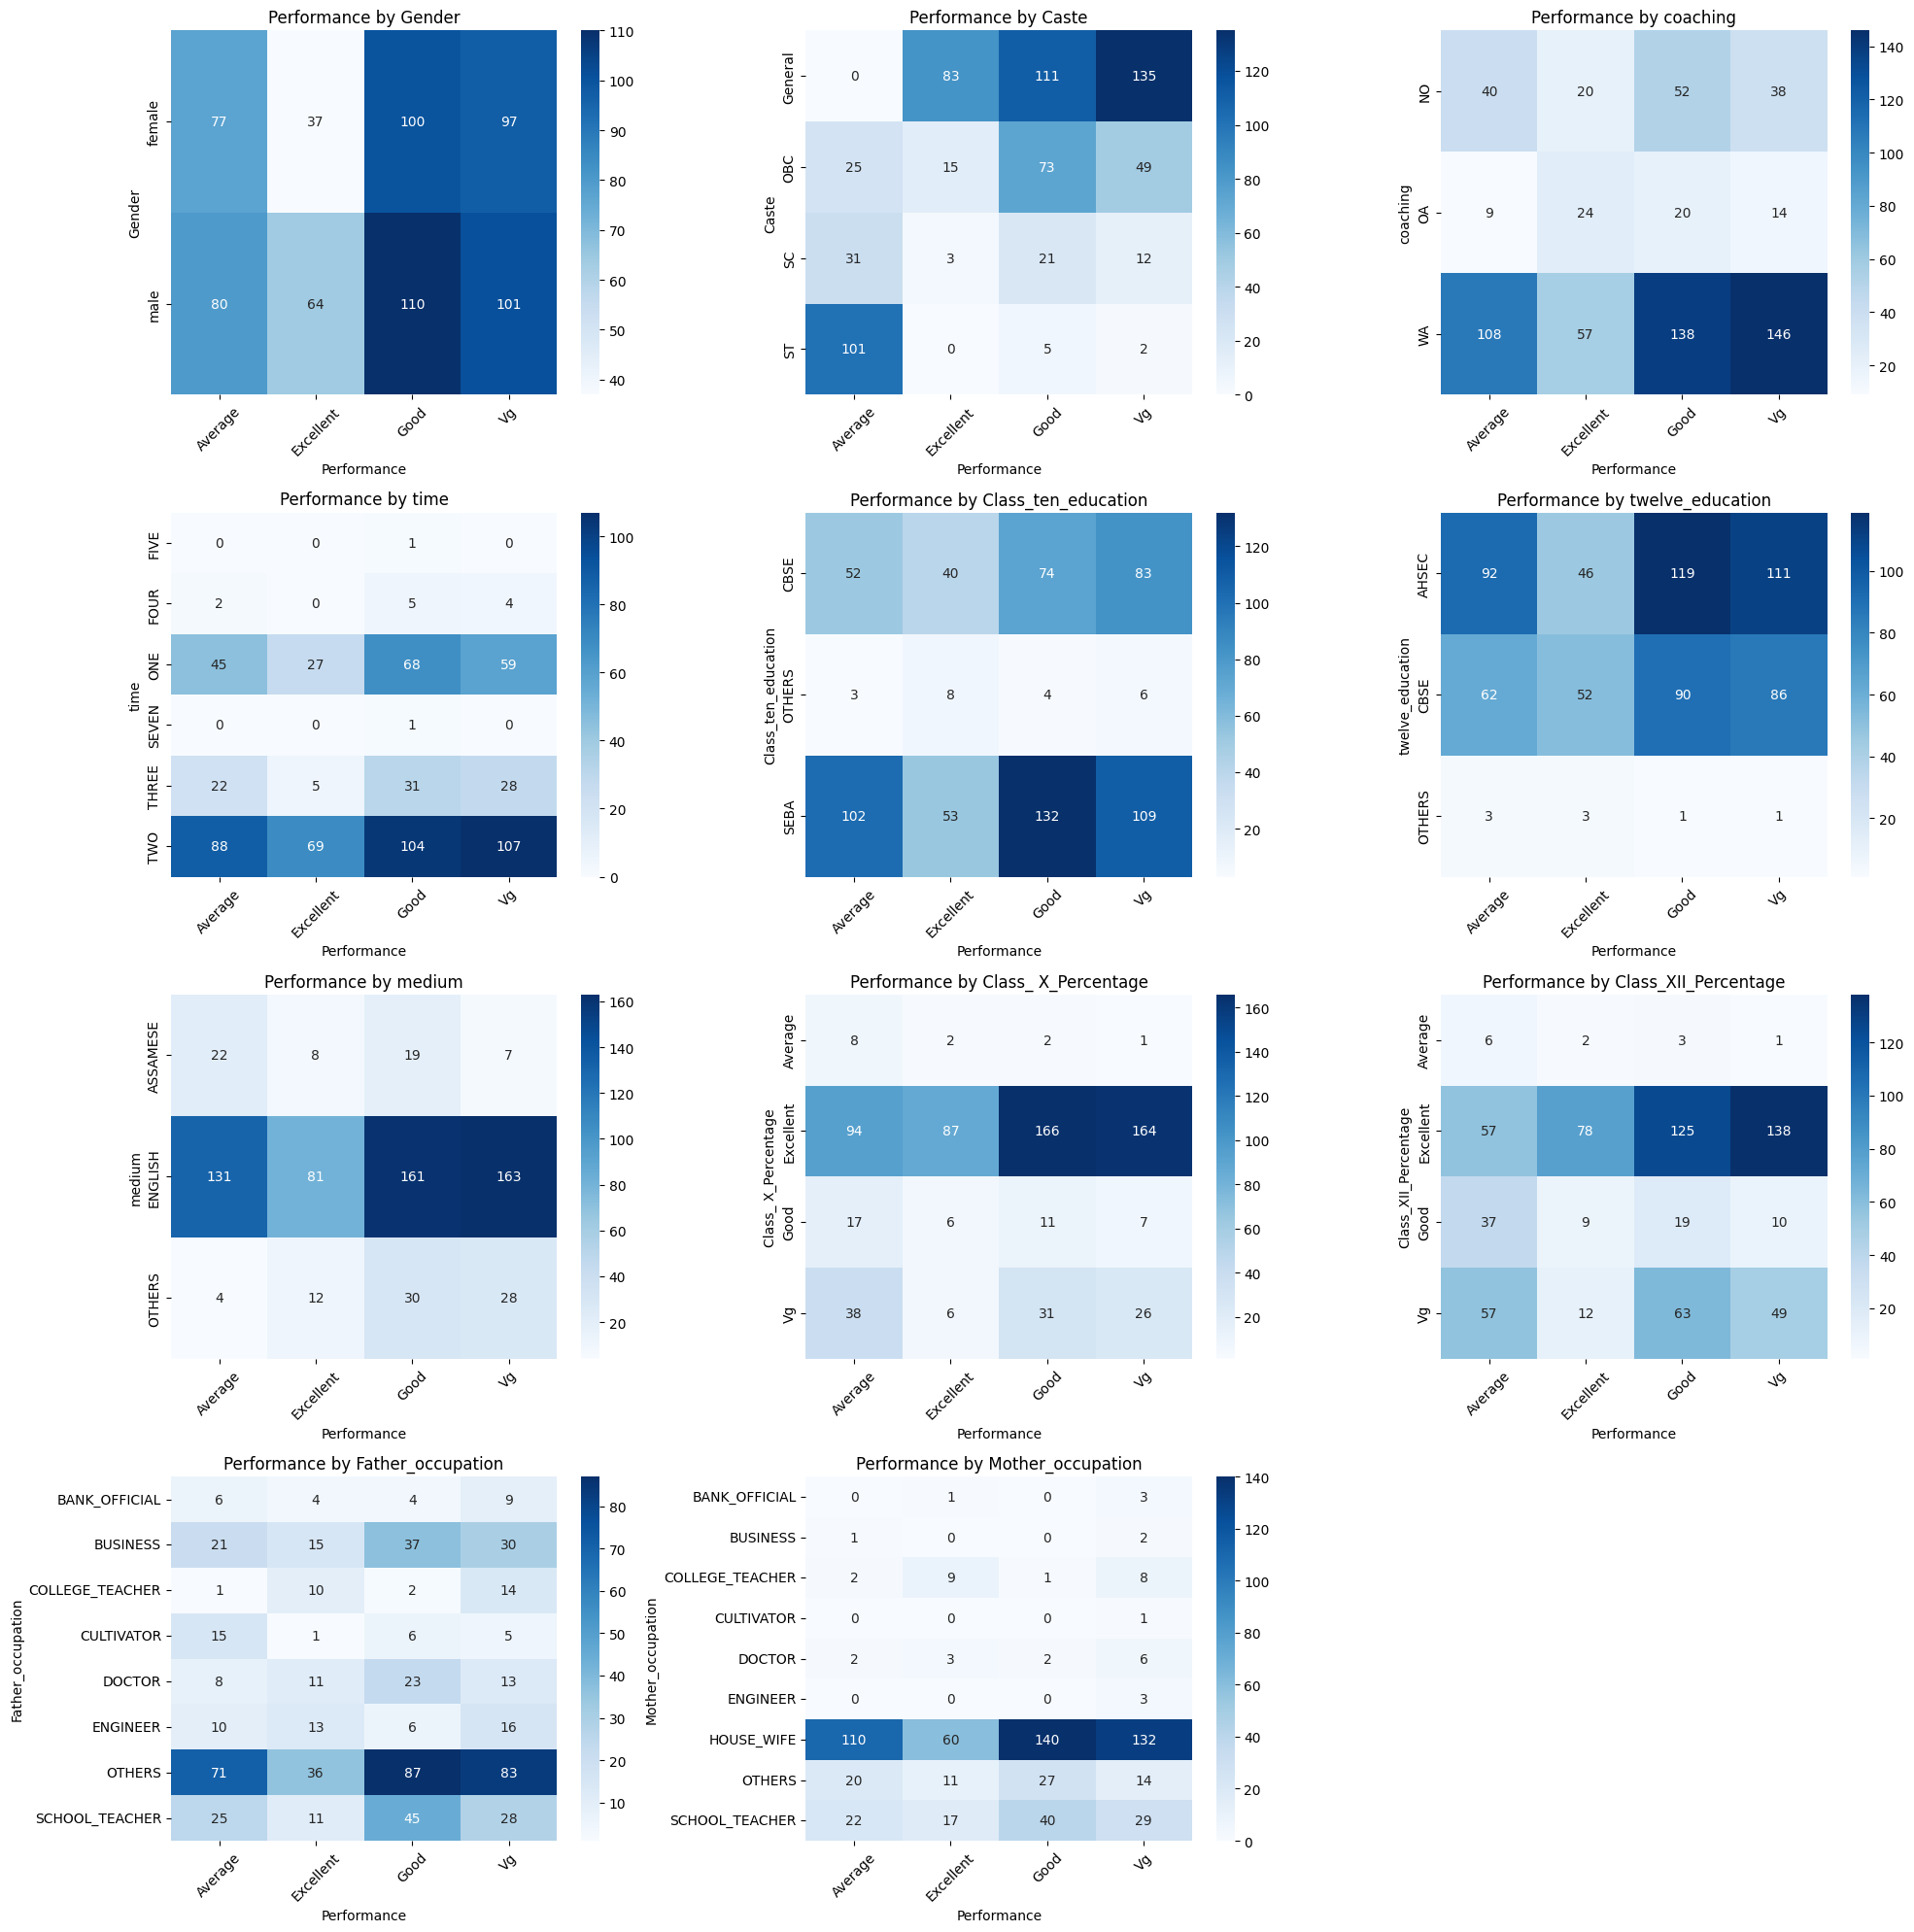

Model Evaluation:


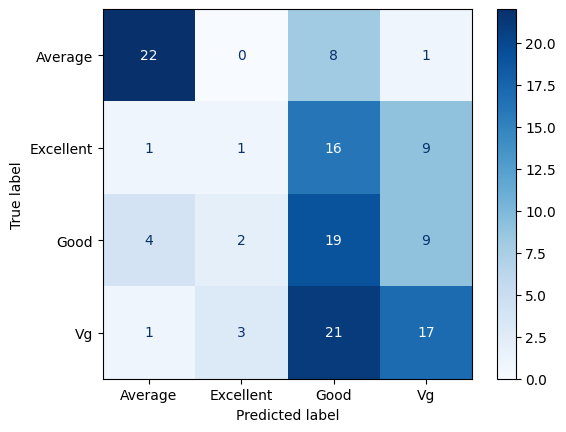

Classification Report:
              precision    recall  f1-score   support

     Average       0.79      0.71      0.75        31
   Excellent       0.17      0.04      0.06        27
        Good       0.30      0.56      0.39        34
          Vg       0.47      0.40      0.44        42

    accuracy                           0.44       134
   macro avg       0.43      0.43      0.41       134
weighted avg       0.44      0.44      0.42       134

Average Accuracy with CV: 0.45679774290248637


In [65]:
# Running the pipeline
filepath = '/home/mekteck/MLOps/MLOps_Team_33/MLOps_Team_33/dataset/CEE_DATA.arff'
pipeline = Model(filepath)
pipeline.run_pipeline()